In [15]:
import pandas as pd

# Assuming your dataframe is named 'df'
def clean_text(text):
    replacements = {
        'Âs': ' ',
        '\xa0': ' ',
        '\n': ' ',
        '\r': ' ',
        '\x96': ' ',
        '\t': ' ',
        "\'s": ' ',
        "'s": ' ',
        '\x92': ' ',
        '\x95': ' ',
        '\x93': ' ',
        '\x94': ' ',
        '\x91': ' ',
        "â": ' '
    }
    for old, new in replacements.items():
        text = text.replace(old, new)
    return text

df = pd.read_pickle("../data/pickle/final_wo_errors.pkl")
df = df.drop(1727)

df['cleaned_text'] = df['description_aims']
df["cleaned_text"] = df["cleaned_text"].fillna("")

# Apply the cleaning function to the 'description_aims' column
df['cleaned_text'] = df['cleaned_text'].apply(clean_text)

In [16]:
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import string
from gensim.models import Phrases
from gensim.models.phrases import Phraser

# Download NLTK resources (run this once)
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

stop_words = stopwords.words('english')
stop_words.extend(["programme", "projects", "project", "programmes"])
stop_words = set(stop_words)

lemmatizer = WordNetLemmatizer()

def tokenize(text):
    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    # Tokenize and lowercase
    tokens = nltk.word_tokenize(text.lower())
    # Remove stop words, non-alphabetic tokens, and lemmatize
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word.isalpha() and word not in stop_words]
    return tokens

# Apply tokenization
df['tokenized_text'] = df['cleaned_text'].apply(tokenize)

[nltk_data] Downloading package punkt to /Users/hieu/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/hieu/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/hieu/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [17]:
stop_words

{'a',
 'about',
 'above',
 'after',
 'again',
 'against',
 'ain',
 'all',
 'am',
 'an',
 'and',
 'any',
 'are',
 'aren',
 "aren't",
 'as',
 'at',
 'be',
 'because',
 'been',
 'before',
 'being',
 'below',
 'between',
 'both',
 'but',
 'by',
 'can',
 'couldn',
 "couldn't",
 'd',
 'did',
 'didn',
 "didn't",
 'do',
 'does',
 'doesn',
 "doesn't",
 'doing',
 'don',
 "don't",
 'down',
 'during',
 'each',
 'few',
 'for',
 'from',
 'further',
 'had',
 'hadn',
 "hadn't",
 'has',
 'hasn',
 "hasn't",
 'have',
 'haven',
 "haven't",
 'having',
 'he',
 'her',
 'here',
 'hers',
 'herself',
 'him',
 'himself',
 'his',
 'how',
 'i',
 'if',
 'in',
 'into',
 'is',
 'isn',
 "isn't",
 'it',
 "it's",
 'its',
 'itself',
 'just',
 'll',
 'm',
 'ma',
 'me',
 'mightn',
 "mightn't",
 'more',
 'most',
 'mustn',
 "mustn't",
 'my',
 'myself',
 'needn',
 "needn't",
 'no',
 'nor',
 'not',
 'now',
 'o',
 'of',
 'off',
 'on',
 'once',
 'only',
 'or',
 'other',
 'our',
 'ours',
 'ourselves',
 'out',
 'over',
 'own',
 'p

In [18]:
from gensim.models import Phrases
from gensim.models.phrases import Phraser

# Build the bigram and trigram models
bigram = Phrases(df['tokenized_text'], min_count=5, threshold=100)
trigram = Phrases(bigram[df['tokenized_text']], threshold=100)

# Convert Phrases models to faster Phraser objects
bigram_mod = Phraser(bigram)
trigram_mod = Phraser(trigram)

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

# Form Bigrams and Trigrams
df['bigrams'] = make_bigrams(df['tokenized_text'])
df['trigrams'] = make_trigrams(df['tokenized_text'])

In [19]:
# Use trigrams for further processing
df['processed_text'] = df['trigrams']

In [20]:
from gensim import corpora

# Create Dictionary
dictionary = corpora.Dictionary(df['processed_text'])

# Filter out extreme values
dictionary.filter_extremes(no_below=5, no_above=0.5)

# Create Corpus
corpus = [dictionary.doc2bow(text) for text in df['processed_text']]

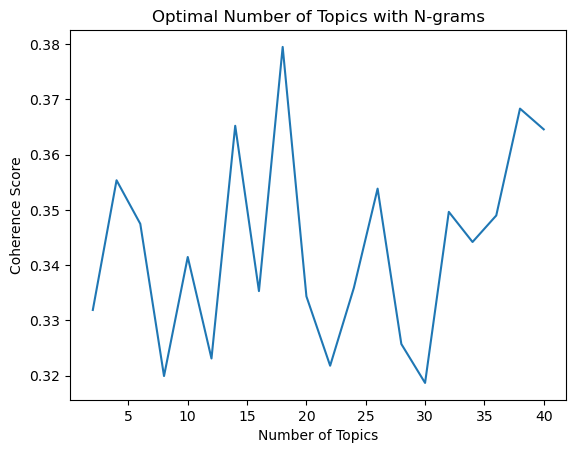

In [21]:
from gensim.models import CoherenceModel
import gensim
import matplotlib.pyplot as plt

coherence_values = []
model_list = []
num_topics_range = range(2, 41, 2)

for num_topics in num_topics_range:
    model = gensim.models.LdaModel(corpus=corpus,
                                   id2word=dictionary,
                                   num_topics=num_topics,
                                   random_state=100,
                                   update_every=1,
                                   chunksize=100,
                                   passes=10,
                                   alpha='auto',
                                   per_word_topics=True)
    model_list.append(model)
    coherencemodel = CoherenceModel(model=model,
                                    texts=df['processed_text'],
                                    dictionary=dictionary,
                                    coherence='c_v')
    coherence_values.append(coherencemodel.get_coherence())

# Plotting the coherence scores
plt.plot(num_topics_range, coherence_values)
plt.xlabel('Number of Topics')
plt.ylabel('Coherence Score')
plt.title('Optimal Number of Topics with N-grams')
plt.show()

In [22]:
model_list[0]

In [23]:
optimal_num_topics = 18  # Update based on new coherence plot

lda_model = gensim.models.LdaModel(corpus=corpus,
                                   id2word=dictionary,
                                   num_topics=optimal_num_topics,
                                   random_state=100,
                                   update_every=1,
                                   chunksize=100,
                                   passes=20,
                                   alpha='auto',
                                   per_word_topics=True)

In [24]:
# Print the topics with their top words
for idx, topic in lda_model.print_topics(-1):
    print(f"Topic: {idx}\nWords: {topic}\n")

Topic: 0
Words: 0.059*"element" + 0.051*"additional" + 0.051*"funding" + 0.043*"march" + 0.038*"vehicle" + 0.037*"capacity" + 0.035*"million" + 0.034*"commitment" + 0.033*"agreement" + 0.033*"fund"

Topic: 1
Words: 0.101*"year" + 0.056*"employer" + 0.050*"school" + 0.034*"term" + 0.034*"period" + 0.032*"offer" + 0.031*"agreed" + 0.028*"december" + 0.025*"july" + 0.023*"june"

Topic: 2
Words: 0.067*"national" + 0.044*"investment" + 0.041*"local" + 0.038*"create" + 0.037*"place" + 0.032*"market" + 0.030*"research" + 0.030*"new" + 0.026*"capital" + 0.025*"life"

Topic: 3
Words: 0.245*"scheme" + 0.194*"phase" + 0.106*"energy" + 0.052*"household" + 0.025*"started" + 0.025*"home" + 0.024*"start" + 0.019*"low_carbon" + 0.018*"share" + 0.015*"grant"

Topic: 4
Words: 0.103*"nh" + 0.071*"care" + 0.063*"patient" + 0.042*"manage" + 0.042*"currently" + 0.041*"information" + 0.038*"provided" + 0.034*"based" + 0.033*"electronic" + 0.031*"system"

Topic: 5
Words: 0.108*"performance" + 0.057*"possible"

In [25]:
def format_topics_sentences(ldamodel, corpus, texts):
    # Initialize a list to hold the results
    rows = []

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        # Sort the topics based on their contribution to the document
        row = sorted(row[0], key=lambda x: (x[1]), reverse=True)
        # Get the dominant topic, its percentage contribution, and keywords
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # Dominant topic
                topic_num = int(topic_num)
                prop_topic = round(prop_topic, 4)
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                rows.append([topic_num, prop_topic, topic_keywords])
            else:
                break

    # Create a DataFrame from the list of rows
    sent_topics_df = pd.DataFrame(rows, columns=['dominant_topic', 'perc_contribution', 'topic_keywords'])
    return sent_topics_df

# Get the dominant topic for each document
df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=df['processed_text'])

# Add to the original dataframe
df = pd.concat([df, df_topic_sents_keywords], axis=1)

In [26]:
from gensim.models import CoherenceModel

coherence_model_lda = CoherenceModel(model=lda_model, texts=df['processed_text'], dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Coherence Score:  0.3880865866678856


In [27]:
import pyLDAvis
import pyLDAvis.gensim_models

# Prepare the visualization
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, dictionary)

# Display in Jupyter notebook
vis

# Save to HTML
pyLDAvis.save_html(vis, 'lda_topics_ngrams.html')

In [38]:
df.drop(columns=['cleaned_text', 'tokenized_text', 'bigrams', 'trigrams', 'processed_text']).to_pickle("../data/pickle/data_with_topics.pkl")